# Problema de regresión

In [1]:
import numpy as np
import pandas as pd
import helper
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(x_trainp, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("Data/train-morpho.csv")
test_morpho = pd.read_csv("Data/t10k-morpho.csv")
#labels = pd.read_csv('Data/train_labels.csv')

In [3]:
train_morpho

,index,area,length,thickness,slant,width,height
0,0,107.3125,50.266504,2.460658,0.231074,14.539572,19.849054
1,1,123.2500,51.198485,2.616601,0.331858,15.387810,19.341053
2,2,78.3750,45.927670,1.891592,-0.212196,20.479656,19.114880
3,3,67.3125,22.849242,2.919769,0.509185,5.358179,19.724599
4,4,91.1875,46.284271,2.247425,0.007590,13.275437,19.527523
...,...,...,...,...,...,...,...
59995,59995,102.1875,61.415999,1.941380,0.366472,11.840672,19.937599
59996,59996,108.5625,46.705844,2.538071,0.364359,13.325950,19.688557
59997,59997,87.0625,44.523864,2.058077,0.257784,14.133500,20.070647
59998,59998,82.2500,53.337572,1.667193,0.310377,15.251961,19.692976


Se encuentra que para cada clase la distrbucion del slant es muy similar.

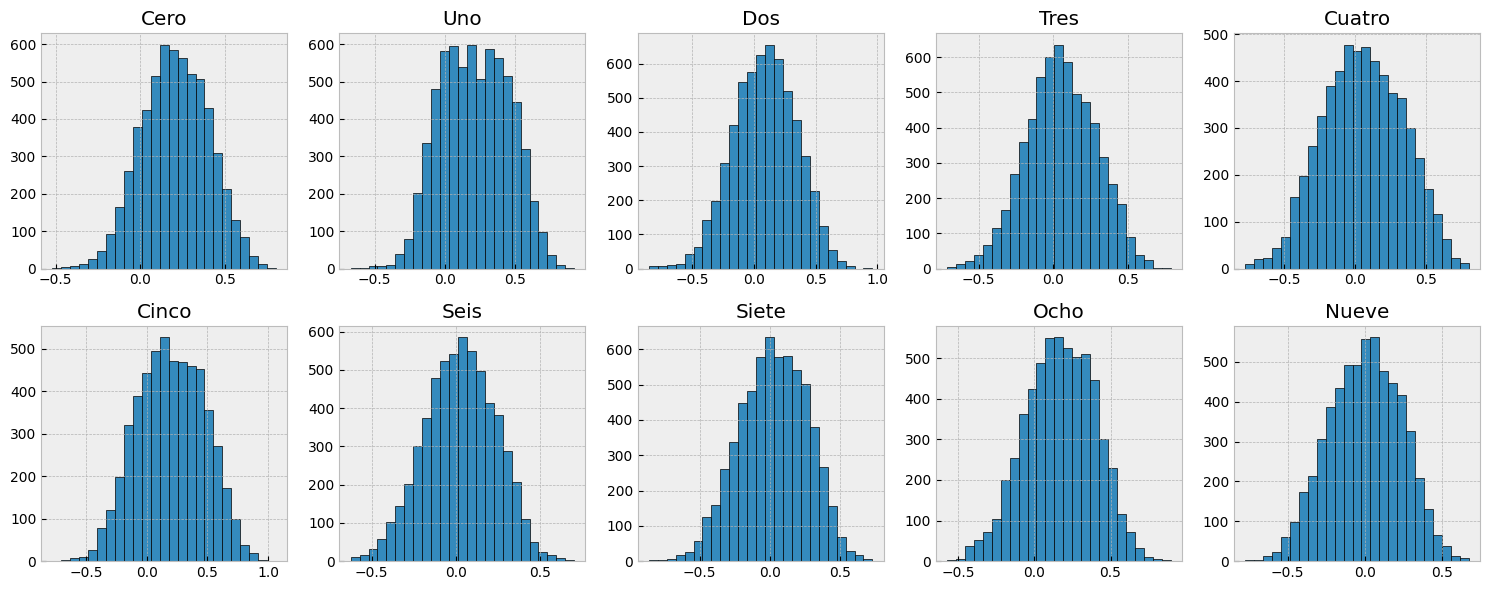

In [4]:
clases = ['Cero', 'Uno', 'Dos', 'Tres', 'Cuatro', 'Cinco', 'Seis', 'Siete', 'Ocho', 'Nueve']
helper.plotHistSlant(train_morpho, y_train, clases)

In [5]:
slant = train_morpho['slant'].to_numpy()

In [6]:
from sklearn.model_selection import train_test_split

x_train, x_val, s_train, s_val = train_test_split(x_trainp, slant, test_size=0.25, random_state=42)
saltear, saltear2, y_train, y_val = train_test_split(x_trainp, y_train, test_size=0.25, random_state=42)

In [7]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Embedding, Concatenate, Input
from tensorflow.keras.optimizers import Adam, Adamax, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

## Modelo en funcion de la imagen

In [8]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(784, activation='relu'))
model.add(BatchNormalization(synchronized=True))
model.add(Dense(784//2, activation='relu'))
model.add(BatchNormalization(synchronized=True))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 392)               307720    
                                                                 
 batch_normalization_1 (Batc  (None, 392)              1568      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [9]:
stp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(loss='MAE', optimizer=Adamax(learning_rate=0.001))
history = model.fit(x = x_train, y = s_train, validation_data = (x_val, s_val), epochs=40, batch_size=128, callbacks=[stp])

Epoch 1/40
352/352 [==============================] - 9s 21ms/step - loss: 0.3245 - val_loss: 0.2009
Epoch 2/40
352/352 [==============================] - 8s 21ms/step - loss: 0.1239 - val_loss: 0.0920
Epoch 3/40
352/352 [==============================] - 8s 22ms/step - loss: 0.0823 - val_loss: 0.0897
Epoch 4/40
352/352 [==============================] - 8s 22ms/step - loss: 0.0657 - val_loss: 0.0664
Epoch 5/40
352/352 [==============================] - 9s 25ms/step - loss: 0.0521 - val_loss: 0.0445
Epoch 6/40
352/352 [==============================] - 8s 22ms/step - loss: 0.0454 - val_loss: 0.0619
Epoch 7/40
352/352 [==============================] - 8s 22ms/step - loss: 0.0421 - val_loss: 0.0357
Epoch 8/40
352/352 [==============================] - 8s 22ms/step - loss: 0.0401 - val_loss: 0.0412
Epoch 9/40
352/352 [==============================] - 8s 22ms/step - loss: 0.0361 - val_loss: 0.0419
Epoch 10/40
352/352 [==============================] - 8s 21ms/step - loss: 0.0351 - val_lo

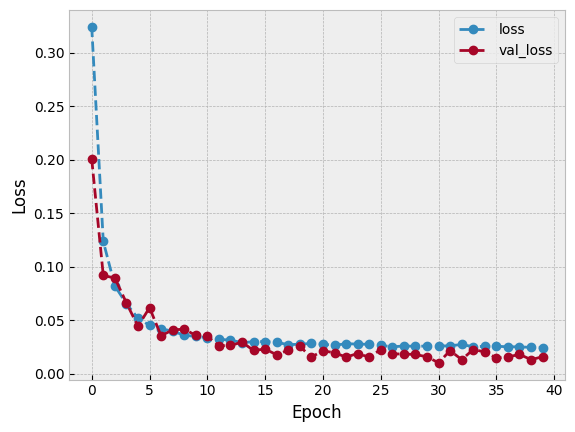

In [10]:
helper.plotLoss(history)

In [13]:
y = model.predict(x_val)

469/469 [==============================] - 2s 3ms/step


## Modelo en funcion de la imagen y la clase

In [9]:
input1 = Input(shape=(28, 28))

input2 = Input(shape=(1,))

first = Embedding(input_dim=10, output_dim=2, input_length=1)(input2)

flat1 = Flatten(input_shape=(1, 2))(first)

flat1 = Model(inputs=input2, outputs=flat1)

second = Flatten(input_shape=(28, 28))(input1)

second = Model(inputs=input1, outputs=second)

merged = Concatenate()([flat1.output, second.output])

act1 = Dense(786//2, activation='relu')(merged)

act2 = Dense(786//4, activation='relu')(act1)

output = Dense(1)(act2)

model2 = Model(inputs=[flat1.input, second.input], outputs=output)

model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         20          ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 2)            0           ['embedding[0][0]']              
                                                                                            

In [10]:
stp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model2.compile(loss='MAE', optimizer=Adam(learning_rate=0.001))
history2 = model2.fit(x = [y_train, x_train], y = s_train, validation_data = ([y_val, x_val], s_val), epochs=80, batch_size=32, callbacks=[stp])

Epoch 1/80
1407/1407 [==============================] - 23s 15ms/step - loss: 1.6142 - val_loss: 0.2589
Epoch 2/80
1407/1407 [==============================] - 20s 14ms/step - loss: 0.0972 - val_loss: 0.0984
Epoch 3/80
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0589 - val_loss: 0.0530
Epoch 4/80
1407/1407 [==============================] - 20s 15ms/step - loss: 0.0487 - val_loss: 0.0590
Epoch 5/80
1407/1407 [==============================] - 20s 14ms/step - loss: 0.0467 - val_loss: 0.0426
Epoch 6/80
1407/1407 [==============================] - 20s 14ms/step - loss: 0.0418 - val_loss: 0.0447
Epoch 7/80
1407/1407 [==============================] - 21s 15ms/step - loss: 0.0398 - val_loss: 0.0473
Epoch 8/80
1407/1407 [==============================] - 20s 14ms/step - loss: 0.0366 - val_loss: 0.0358
Epoch 9/80
1407/1407 [==============================] - 19s 14ms/step - loss: 0.0327 - val_loss: 0.0291
Epoch 10/80
1407/1407 [==============================] - 20s 15m

In [15]:
y2 = model2.predict([y_val, x_val])

469/469 [==============================] - 2s 5ms/step


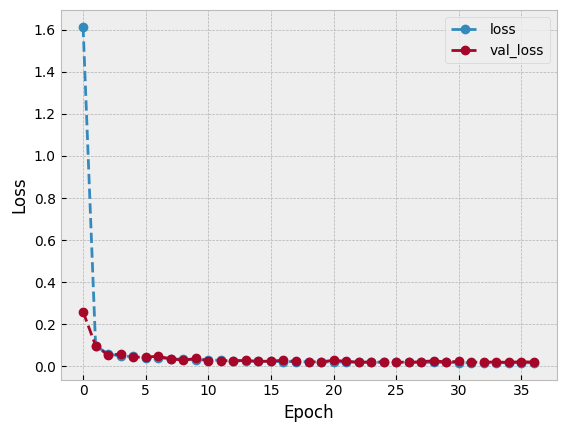

In [16]:
helper.plotLoss(history2)

In [17]:
emb = model2.get_weights()[0]

Graficando los pesos de la capa embedding podemos encontrar cuales clases el modelo determino como estando mas cercanas entre si. 

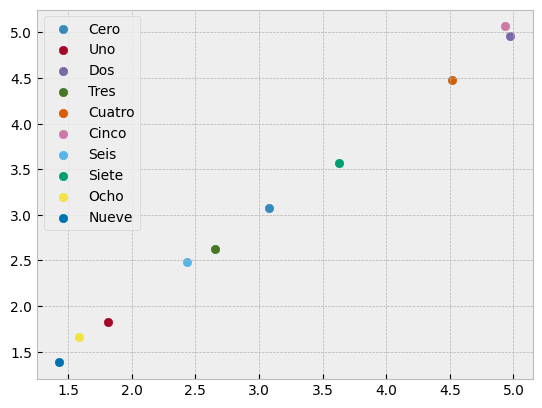

In [18]:
for idx, clase in enumerate(clases):
    plt.scatter(emb[idx, 0], emb[idx, 1], label=clase)
plt.legend()
plt.show()

## Modelo en funcion de la imagen y una variable mas

Visualizando la variacion frente a el slant, se selecciona la length como la entrada continua adicional.

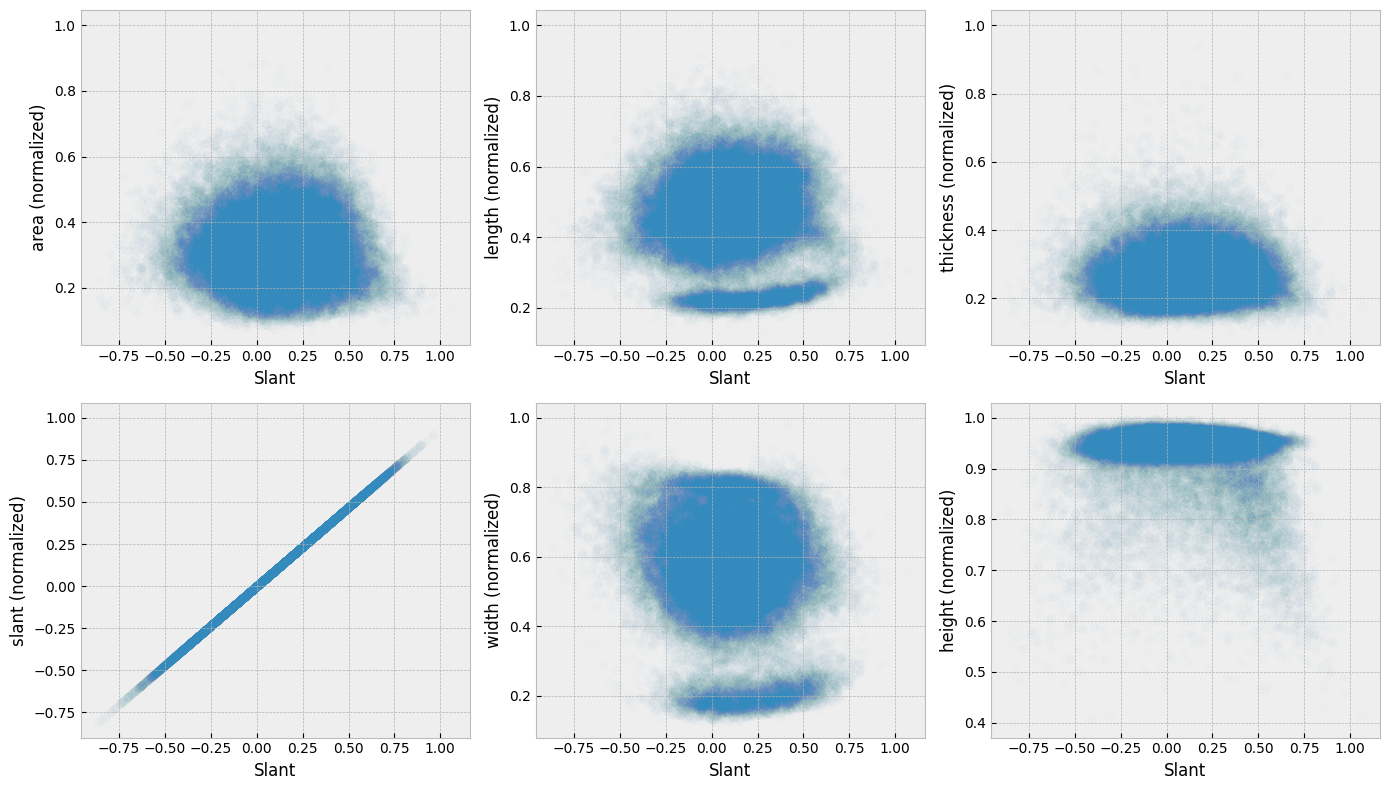

In [23]:
helper.plotScatters(train_morpho)

In [11]:
p3input1 = Input(shape=(28, 28))

p3input2 = Input(shape=(1,))

p3relu2 = Dense(1, activation='linear')(p3input2)

p3relu2 = Model(inputs=p3input2, outputs=p3relu2)

p3second = Flatten(input_shape=(28, 28))(p3input1)

p3second = Model(inputs=p3input1, outputs=p3second)

p3merged = Concatenate()([p3relu2.output, p3second.output])

p3act1 = Dense(786//2, activation='relu')(p3merged)

p3norm1 = BatchNormalization(synchronized=True)(p3act1)

p3act2 = Dense(786//4, activation='relu')(p3norm1)

p3norm2 = BatchNormalization(synchronized=True)(p3act2)

p3output = Dense(1)(p3norm2)

model3 = Model(inputs=[p3relu2.input, p3second.input], outputs=p3output)

model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 1)            2           ['input_2[0][0]']                
                                                                                                  
 flatten_1 (Flatten)            (None, 784)          0           ['input_1[0][0]']                
                                                                                            

In [12]:
h = train_morpho['length'].to_numpy()
saltear, saltear2, h_train, h_val = train_test_split(x_trainp, h/max(h), test_size=0.25, random_state=42)

In [13]:
stp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model3.compile(loss='MAE', optimizer=Adam(learning_rate=0.001))
history3 = model3.fit(x = [h_train, x_train], y = s_train, validation_data = ([h_val, x_val], s_val), epochs=100, batch_size=32, callbacks=[stp])

Epoch 1/100
1407/1407 [==============================] - 15s 10ms/step - loss: 0.1435 - val_loss: 0.0485
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0564 - val_loss: 0.0603
Epoch 3/100
1407/1407 [==============================] - 15s 10ms/step - loss: 0.0522 - val_loss: 0.0293
Epoch 4/100
1407/1407 [==============================] - 15s 11ms/step - loss: 0.0489 - val_loss: 0.0312
Epoch 5/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0468 - val_loss: 0.0278
Epoch 6/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0463 - val_loss: 0.0311
Epoch 7/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0449 - val_loss: 0.0280
Epoch 8/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0439 - val_loss: 0.0264
Epoch 9/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0428 - val_loss: 0.0207
Epoch 10/100
1407/1407 [==============================] - 15s

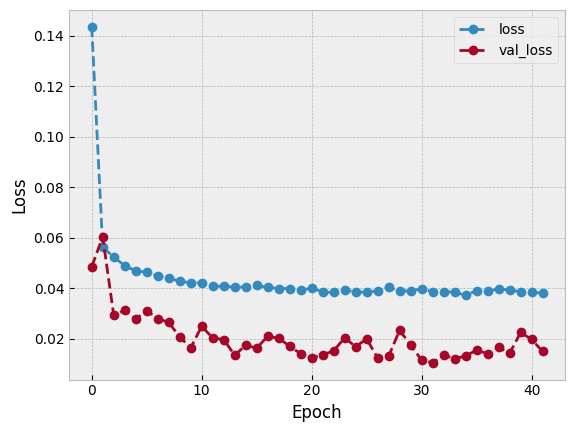

In [14]:
helper.plotLoss(history3)